# Machine Learning LAB 3: LINEAR REGRESSION

Course 2024/25: *F. Chiariotti*

The notebook contains some simple tasks to be performed with **LINEAR REGRESSION MODELS**.

Complete all the **required code sections**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## VR traffic prediction

In this notebook, we will explore the prediction of Virtual Reality (VR) traffic. The data come from the paper:

Lecci, Mattia, _et al._ "An open framework for analyzing and modeling XR network traffic." IEEE Access 9 (2021): 129782-129795.

The VR game Virus Popper was instantiated on a computer through the RiftCat application: the user could then see the virtual content on their phone, which was strapped to their head with a Cardboard viewer. The file virus_popper.csv contains three columns from the traffic capture:
idx    | frame size (B) |  time (s)
0      | 38424          |  0.0
1      | 39801          |  0.01944
...

The game was run at 60 frames per second, with a target rate of 30 Mb/s. The task is then to predict the size of the next frame, given the past N frames. This was explored in another paper:

Chiariotti, Federico, _et al._ "Temporal characterization and prediction of vr traffic: A network slicing use case." IEEE Transactions on Mobile Computing 23.5 (2023): 3890-3908.

---

## Import all the necessary Python libraries

In [1]:
import numpy as np
import pandas as pd
import random as rnd
from matplotlib import pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split

np.random.seed(1)

def load_dataset(filename):
    data_train = pd.read_csv(filename)
    data = data_train.iloc[:, 1].values # Get the second column (frame size) as the input
    return data

# Load the dataset
data = load_dataset('data/virus_popper.csv')

## Prepare the data and create training and test sets

In this case, we are learning a time series: let us consider a memory of 2 samples, i.e., use X[n-1] and X[n-2] to predict X[n].

In [2]:
# Normalize the dataset
avg_size = np.mean(data)
norm_data = np.asarray(data) / avg_size

# Compute the splits and prepare the columns
m_training = int(0.75*norm_data.shape[0])

X_training = np.ones([m_training - 2, 3])
X_training[:,1] = norm_data[: m_training - 2]
X_training[:,2] = norm_data[1 : m_training - 1]
Y_training = norm_data[2 : m_training]


X_test = np.ones([norm_data.shape[0] - m_training - 2, 3])
X_test[:,1] = norm_data[m_training : -2]
X_test[:,2] = norm_data[m_training + 1 : -1]
Y_test = norm_data[m_training + 2:]

print(np.shape(X_training), np.shape(Y_training), np.shape(X_test), np.shape(Y_test))

(25878, 3) (25878,) (8625, 3) (8625,)


## Least Squares linear regression

Train and evaluate the LS regressor on the data

In [3]:
A = np.dot(X_training.T, X_training)

A = np.linalg.inv(A)

A

array([[ 0.00163978, -0.00080261, -0.00080291],
       [-0.00080261,  0.00172933, -0.0009245 ],
       [-0.00080291, -0.0009245 ,  0.00172958]])

In [4]:
# Least squares solution
def least_squares(X_matrix: np.ndarray, labels: np.ndarray) -> None:
    ## TODO: Run the LS algorithm without regularization

    A = np.dot(X_matrix.T, X_matrix)
    b = np.dot(X_matrix.T, labels)
    w = np.dot(np.linalg.inv(A), b)

    return w
    

def evaluate_model(x, y, coeff):
    ## TODO: Return the average MSE for the set over which we evaluate
    mse = np.sum((np.dot(x, coeff.T) - y)**2)/len(y)

    return mse

In [5]:
# Run the LS training and test it on the test data
trained_model = least_squares(X_training, Y_training)
print('Training RMSE:', np.sqrt(evaluate_model(X_training, Y_training, trained_model)) * avg_size)
mse = evaluate_model(X_test, Y_test, trained_model)
print('Model coefficients:', trained_model)
print('Root MSE:', np.sqrt(mse) * avg_size)

Training RMSE: 9070.165039219852
Model coefficients: [0.36986742 0.20348677 0.42565451]
Root MSE: 7712.354721539114


---

## Least Squares with Tikhonov regularization

Perform K-fold cross validation with $\lambda\in\{0, 0.1, 1, 10\}$

In [6]:
test = np.eye(10) * 3


In [7]:
# Least squares solution
def regularized_least_squares(X_matrix: np.ndarray, labels: np.ndarray, lambda_par: np.ndarray) -> None:
    # Create A and b as in unregularized LS
    A = np.transpose(X_matrix).dot(X_matrix)
    b = np.transpose(X_matrix).dot(labels)
    # Add the regularization part in the inverse
    coeff = np.linalg.inv(A + lambda_par * np.eye(np.shape(A)[0])).dot(b)
    return coeff

    

def K_fold(X_training: np.ndarray, Y_training: np.ndarray, lambda_vec: np.ndarray, K: np.ndarray) -> None:
    results = []

    #Ensures that does not go above the number of train data
    #! IMPORTANT

    fracData = int(np.floor(len(X_training)/K))

    for l in lambda_vec:

        ErrorForFold = []

        for i in range(K):

            #separate train into train and validation
            idx = np.arange(len(X_training))
            #! IMPORTANT
            valIdx = np.arange(fracData) + i*fracData

            trainIdx = [i for i in idx if i not in valIdx]
            
            xVal, yVal = X_training[valIdx], Y_training[valIdx]
            xTrain, yTrain = X_training[trainIdx], Y_training[trainIdx]

            FitCoeff = regularized_least_squares(xTrain, yTrain, l)
            mse = evaluate_model(xVal, yVal, FitCoeff)

            ErrorForFold.append(mse)


        results.append(np.mean(ErrorForFold))
    
    bestRes = np.min(results)
    bestLambda = lambda_vec[np.argmin(results)]

    best = (bestRes, bestLambda)


    return best, results

(0.02215650302762246, 99) [0.022586225857636512, 0.022578944514582054, 0.02257175644427977, 0.022564660090417528, 0.022557653929379244, 0.022550736469413416, 0.022543906249832407, 0.02253716184023077, 0.022530501839730467, 0.022523924876245206, 0.022517429605768018, 0.022511014711677865, 0.022504678904068598, 0.022498420919095367, 0.022492239518339414, 0.022486133488193248, 0.022480101639260276, 0.02247414280577488, 0.02246825584503543, 0.022462439636854858, 0.022456693083027265, 0.02245101510680738, 0.022445404652406183, 0.022439860684499678, 0.02243438218775109, 0.022428968166346465, 0.022423617643542317, 0.022418329661226588, 0.022413103279490212, 0.022407937576210856, 0.022402831646648115, 0.022397784603049083, 0.022392795574264074, 0.022387863705373122, 0.02238298815732214, 0.02237816810656862, 0.022373402744736242, 0.022368691278279368, 0.02236403292815519, 0.022359426929505034, 0.022354872531343332, 0.022350368996255494, 0.022345915600102528, 0.02234151163173361, 0.0223371563927

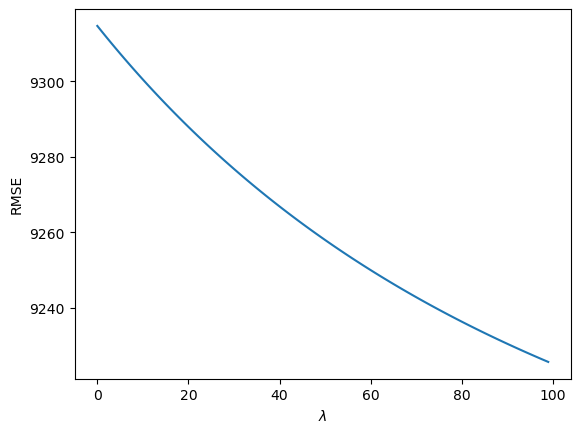

In [8]:
# Run the training with K-fold cross-validation and plot the score
K = 5
lambda_par = range(100)

best_model, results = K_fold(X_training, Y_training, lambda_par, K)
print(best_model, results)
plt.plot(lambda_par, np.sqrt(results) * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()


In [9]:
# Plot the results for the regularized models on the test set
test_scores = np.zeros(len(models))

for i in range(len(models)):
    test_scores[i] = evaluate_model(X_test, Y_test, models[i])

plt.plot(lambda_par, np.sqrt(test_scores) * avg_size)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.show()


NameError: name 'models' is not defined

### EXTRA

Can you figure out the best amount of memory to use?
